In [1]:
import re
import numpy as np

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as np array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

def resizeImage(image, newSize):
    a = image.shape[0]
    b = newSize
    ratio = a/b
    resizeAToB= np.zeros((a,b))
    for i in range(a):
        for j in range(b): 
            if i//ratio == j:
                resizeAToB[i,j] = 1. / ratio
    return np.matmul(resizeAToB.T, np.matmul(image, resizeAToB))

def flatten_list_of_strings(args):
    output = ''
    for s in args:
        output += s
        output += ' '
    return output

def flatten_list_of_args(args):
    output = ''
    for s in args:
        if s[0] == '-':
            s = s[1:]
        output += s
        output += ' '
    return output

In [2]:
from subprocess import Popen, PIPE

class ExpRunner():

    def __init__(self, input_image_path, discretization_n, amount_of_rays, random_noise, exp_list):
        self.input_image_path = input_image_path
        self.discretization_n = discretization_n
        self.amount_of_rays = amount_of_rays
        self.random_noise = random_noise
        self.exp_list = exp_list
        
        self.run_logs = {}
        
        self.setup_args()

    def setup_args(self):

        tp_exec = '../build/tp3'
        self.exp_name = flatten_list_of_args(self.exp_list)

        self.output_image_name = "{}_{}_celdas_{}_ruido_{}_rayos".format(
                self.exp_name, self.discretization_n, self.random_noise, self.amount_of_rays)

        output_image_dir = "../results/"

        self.output_image_path = output_image_dir + self.output_image_name + '.pgm'
        self.output_image_path = self.output_image_path.replace(' ', '_')

        self.args = [tp_exec, "-i", str(self.input_image_path), "-o", str(self.output_image_path), 
                "-n", str(self.discretization_n), "-r", str(self.random_noise)]
        for exp in self.exp_list:
            if 'g15' in exp or 'g14' in exp:
                self.args.extend(exp.split())
                self.args.append(str(self.amount_of_rays//len(self.exp_list)))
            else:
                self.args.extend([exp, str(self.amount_of_rays//len(self.exp_list))])
        print("Run command:")
        print(flatten_list_of_strings(self.args))
        print
    
    
    def run_executable(self):
        p = Popen(self.args, stdout=PIPE, bufsize=1)
        with p.stdout:
            for line in iter(p.stdout.readline, b''):
                try:
                    key, val = line[:-1].split(':')
                    if key in ['error','debug']:
                        print(line)
                    elif key in ['csv']:
                        pass
                    else:
                        self.run_logs[key] = float(val)
                except:
                    # print('COMANDO FEO: {}'.format(line))
                    pass
        p.wait() # wait for the subprocess to exit
        self.save_run_logs_to_file()
        self.output_image = read_pgm(self.output_image_path)  # .reshape(-1)

    def save_run_logs_to_file(self):
        filename = self.output_image_path + '.logs'
        file = open(filename, "w") 
        for k,v in self.run_logs.items():
            file.write('{}:{}\n'.format(k,v))

    def read_run_logs_from_file(self):
        filename = self.output_image_path + '.logs'
        file = open(filename, "r") 
        while True:
            line = file.readline()
            if line == '':
                break
            k,v =line.split(':')
            self.run_logs[k] = float(v)
            
    def print_run_logs(self):
        print(self.run_logs)

    def read_or_execute(self):
        try:
            self.read_run_logs_from_file()
            self.output_image = read_pgm(self.output_image_path)  # .reshape(-1)
            print("Loaded without running.")
        except:
            print("Running exp.")
            self.run_executable()
            
    def run_exp(self):

        self.read_or_execute()

        process_data = {'discretization_n':float(self.discretization_n), 
                'random_noise': float(self.random_noise),
                'rayos': float(self.amount_of_rays),
                'image': self.output_image,
                'exp_name': self.exp_name,
                'output_image_name': self.output_image_name}


        return dict(self.run_logs, **process_data)

#### Run exp

In [57]:
input_image_path = "../imgs_TC/tomo.pgm"
divisors_of_100 = [20]
import pandas as pd
output = []
for div in divisors_of_100:
    exp_names = [['-g4']]
    # exp_names.extend([['-g14b '+focos+' -g14a'] for focos in ['50']])
    for exp in exp_names:
        for random in [0]: # [0, 100, 200, 400]:        
            for amount_of_rays in [3000]: # [1000,2000,3000,4000,5000]:
                e = ExpRunner(input_image_path, div, amount_of_rays, random, exp)
                output.append(e.run_exp())               
                # e.print_run_logs()

outputs_df = pd.DataFrame(output)
outputs_df.head()

Run command:
../build/tp3 -i ../imgs_TC/tomo.pgm -o ../results/g4__20_celdas_0_ruido_3000_rayos.pgm -n 20 -r 0 -g4 3000 

Running exp.
debug: Ejecutando analisis tomografico.

debug: Matrices de rayos creadas.

debug: Factorizacion SVD calculada.

debug: analisis executed



,Current number of retries,discretization_n,exp_name,image,numero_de_condicion,output_image_name,random_noise,rayos,tiempo_armado_matrices,tiempo_autovectores,tiempo_cml,tiempo_rayos
0,1.0,20.0,g4,"[[9728, 0, 10752, 0, 1024, 1024, 11776, 17920,...",48.1689,g4 _20_celdas_0_ruido_3000_rayos,0.0,3000.0,22070.0,8516490.0,1359.0,165.0


#### Input images

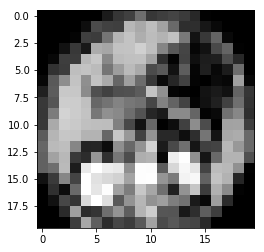

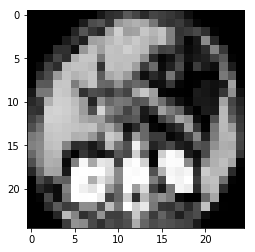

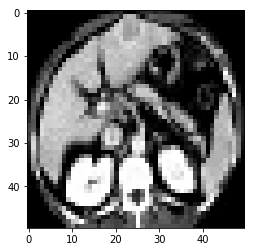

In [11]:
from matplotlib import pyplot 
input_image_path = "../imgs_TC/tomo.pgm"
input_image = read_pgm(input_image_path, byteorder='<')
divisors = [20,25,50]
resized_input_images = {div: resizeImage(input_image, div) for div in divisors}
for div in divisors:    
    resized_input_image = resized_input_images[div]
    pyplot.imshow(resized_input_image, pyplot.cm.gray)
    pyplot.savefig('./resized_tomo{}x{}.png'.format(div,div))
    pyplot.show()
    

#### Reconstructed images

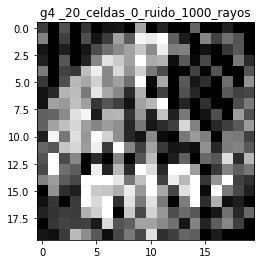

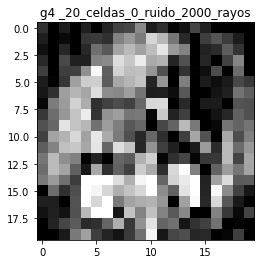

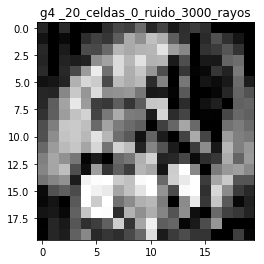

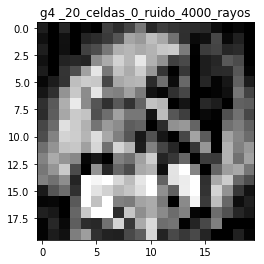

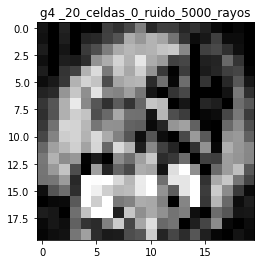

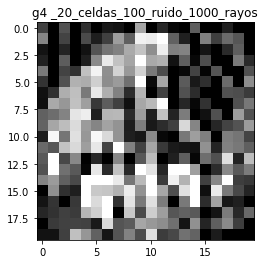

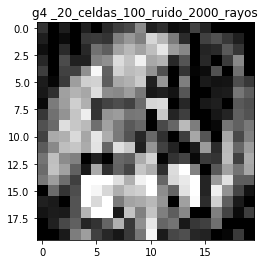

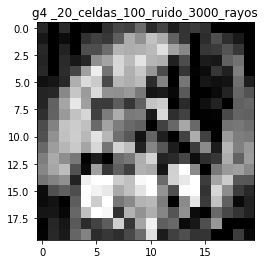

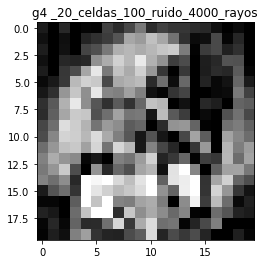

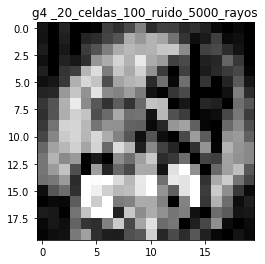

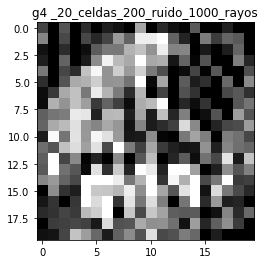

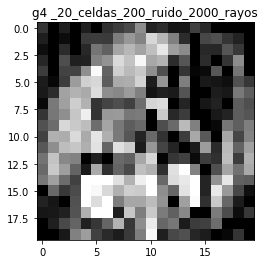

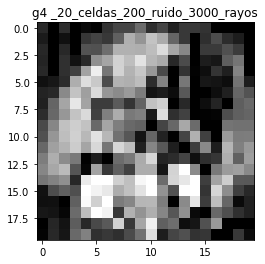

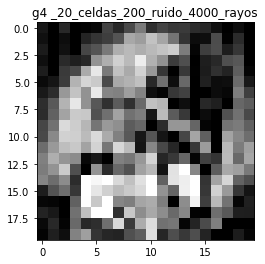

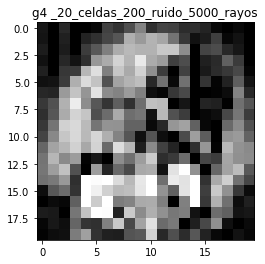

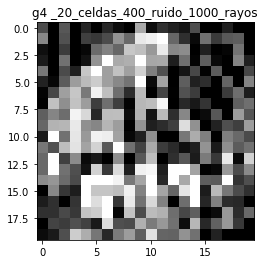

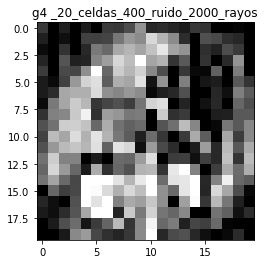

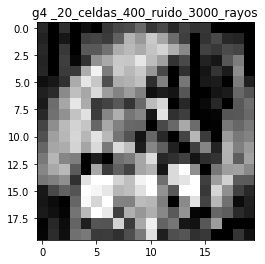

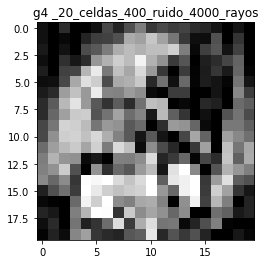

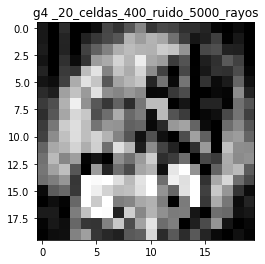

In [12]:
image_and_metadata_headers = ['image', 'output_image_name']
for i,row in outputs_df[image_and_metadata_headers].iterrows():
    output_image_name = row['output_image_name']
    pyplot.title(output_image_name)
    pyplot.imshow(row['image'], pyplot.cm.gray)
    pyplot.show()



In [52]:
### check distribution of output pixels values

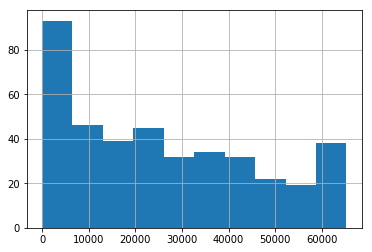

In [50]:
pd.Series(outputs_df['image'][5].reshape(-1)).hist()
#plt.show()

#### Compute mean squared error

In [19]:
from sklearn.metrics import mean_squared_error
def mse(test, pred):
    return sum([diff**2 for diff in test - pred]) / len(test)
    
def mse_vs_benchmark(resized_input_images, output_img):
    output_img = output_img.reshape(-1)
    div = np.sqrt(len(output_img))
    resized_input_image = resized_input_images[div].reshape(-1)
    return mse(resized_input_image, output_img)

from functools import partial
mse_vs_resized_input_images = partial(mse_vs_benchmark,resized_input_images)

outputs_df['mse_vs_benchmark'] = outputs_df['image'].map(mse_vs_resized_input_images)
outputs_df.head()

,Current number of retries,discretization_n,exp_name,image,numero_de_condicion,output_image_name,random_noise,rayos,tiempo_armado_matrices,tiempo_autovectores,tiempo_cml,tiempo_rayos,mse_vs_benchmark
0,NaN,20.0,g4,"[[15360, 0, 20736, 0, 13824, 0, 4864, 5376, 0,...",57.5332,g4 _20_celdas_0_ruido_1000_rayos,0.0,1000.0,9565.0,6940630.0,577.0,59.0,1.066274e+09
1,NaN,20.0,g4,"[[12288, 0, 7168, 0, 8448, 0, 9216, 16640, 181...",52.2008,g4 _20_celdas_0_ruido_2000_rayos,0.0,2000.0,16599.0,7528550.0,982.0,99.0,1.012378e+09
2,1.0,20.0,g4,"[[9728, 0, 10752, 0, 1024, 1024, 11776, 17920,...",48.1689,g4 _20_celdas_0_ruido_3000_rayos,0.0,3000.0,23878.0,8709540.0,1450.0,150.0,9.959096e+08
3,NaN,20.0,g4,"[[7680, 0, 9728, 0, 2048, 0, 16128, 11520, 174...",47.7156,g4 _20_celdas_0_ruido_4000_rayos,0.0,4000.0,33393.0,9103960.0,1958.0,194.0,9.854972e+08
4,NaN,20.0,g4,"[[5120, 0, 8704, 0, 1280, 512, 15872, 12544, 1...",45.7098,g4 _20_celdas_0_ruido_5000_rayos,0.0,5000.0,35920.0,9848210.0,2419.0,265.0,9.869796e+08


random_noise vs mse_vs_benchmark plots


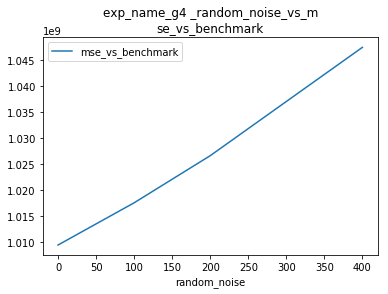

In [14]:
from textwrap import wrap
%matplotlib inline 
def plot_param_vs_mse_per_exp(outputs_df, param_key):
    print('{} vs {} plots'.format(param_key, 'mse_vs_benchmark'))
    for exp_name in set(outputs_df['exp_name']):
        exp_filtered = outputs_df[(outputs_df['exp_name'] == exp_name)]

        exp_filtered = exp_filtered.groupby([param_key],as_index=False)['mse_vs_benchmark'].mean()

        title = 'exp_name_{}_{}_vs_{}'.format(exp_name,param_key, 'mse_vs_benchmark')
        title = "\n".join(wrap(title, 30))
        exp_filtered.plot(param_key, 'mse_vs_benchmark',title=title)

def plot_param_vs_times_per_exp(outputs_df, param_key):
    time_keys = ['tiempo_rayos',\
                'tiempo_armado_matrices',\
                'tiempo_cml',\
                'tiempo_autovectores']
    print('{} vs time plots'.format(param_key))
    for exp_name in set(outputs_df['exp_name']):
        exp_filtered = outputs_df[(outputs_df['exp_name'] == exp_name)]
        exp_filtered = exp_filtered.groupby([param_key],as_index=False)[time_keys].mean()

        title = 'exp_name_{}_{}_vs_time'.format(exp_name,param_key)
        title = "\n".join(wrap(title, 30))
        exp_filtered.plot(param_key, time_keys,title=title)

plot_param_vs_mse_per_exp(outputs_df, 'random_noise')

rayos vs mse_vs_benchmark plots
discretization_n vs mse_vs_benchmark plots
random_noise vs mse_vs_benchmark plots


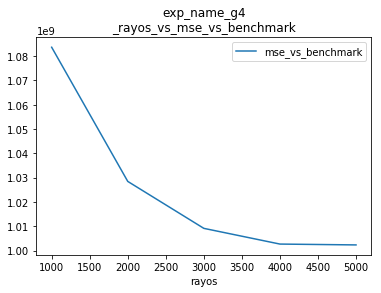

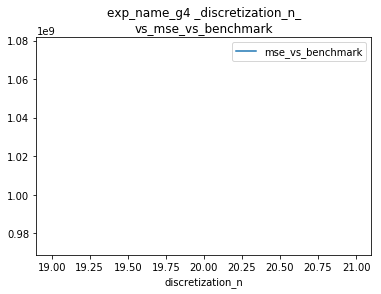

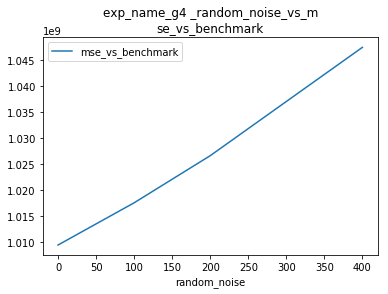

In [15]:
plot_param_vs_mse_per_exp(outputs_df, 'rayos')
plot_param_vs_mse_per_exp(outputs_df, 'discretization_n')
plot_param_vs_mse_per_exp(outputs_df, 'random_noise')

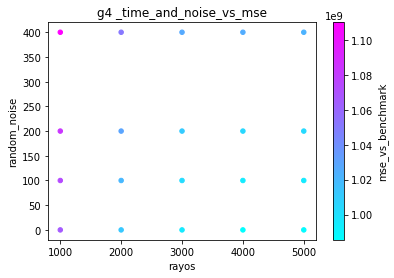

In [16]:
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from textwrap import wrap        

for exp_name in set(outputs_df['exp_name']):
    exp_filtered = outputs_df[(outputs_df['exp_name'] == exp_name)]

    exp_filtered['time'] = outputs_df['tiempo_rayos'] +\
                            outputs_df['tiempo_armado_matrices'] +\
                            outputs_df['tiempo_cml'] +\
                            outputs_df['tiempo_autovectores']
                
    title =  '{}_time_and_noise_vs_mse'.format(exp_name)
    title = "\n".join(wrap(title, 30))
    fig, ax = plt.subplots()
    exp_filtered.plot.scatter(x='rayos',y='random_noise', c='mse_vs_benchmark',title=title, legend=True, cmap="cool",ax=ax);
